<a href="https://colab.research.google.com/github/IssacChew/Japanese-Handwritting-Recognition/blob/main/Japanese_Online_Handwriting_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
#Dataset used  - ETL Character Database
#Katakana (ETL1)
#Hiragana (ETL8)
#Kanji (ETL8)

In [ ]:
!ls "/content/MyDrive/MyDrive/Japanese Handwritting Recognition"

 ETL8B	        Handwritten-Japanese-Recognition-master   Kanji
 Files	        Hiragana				  Katakana
'Files ver.2'   kanji					  Kuzushiji


In [ ]:

#%tensorflow_version 1.13.1
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import numpy as np 
import pandas as pd
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import collections
from collections import defaultdict
import skimage.transform
from sklearn.model_selection import train_test_split

import time
import copy

import struct
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
tf.__version__

In [ ]:
#Read Katakana
def read_record_ETL1G(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('P')
    return r + (iL,)

def read_kana():
    katakana = np.zeros([51, 1411, 63, 64], dtype=np.uint8) #51 characters, 1411 writers, img size = 63*64
    for i in range(7,14):
        filename = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Handwritten-Japanese-Recognition-master/ETL1/ETL1C_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            if i!=13: #file 13 only has 3 characters, others have 8 characters
                limit = 8
            else:
                limit=3
            for dataset in range(limit):
                for j in range(1411):
                    try :
                        r = read_record_ETL1G(f)
                        katakana[(i - 7) * 8 + dataset, j] = np.array(r[-1])
                    except struct.error: #two images are blank according to the ETL website, so this prevents any errors
                        pass
    np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kana.npz", katakana)

In [ ]:
read_kana()

In [ ]:
#Read Hiragana
def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_hira():
    hiragana = np.zeros([71, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Handwritten-Japanese-Recognition-master/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                            char += 1
    np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana.npz", hiragana)
    


In [ ]:
read_hira()

In [ ]:
#Read Kanji
def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_kanji():
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Handwritten-Japanese-Recognition-master/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji.npz", kanji)


In [ ]:
read_kanji()

In [ ]:
#Preprocess katakana
kana = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

#make the numbers range from 0 to 1
kana = kana/np.max(kana)

#51 is the number of different katakana (3 are duplicates so in the end there are 48 classes)
#1411 writers
#transform the size of images to 48*48
kana_train_images = np.zeros([51 * 1411, 48, 48], dtype=np.float32)

for i in range(51 * 1411): #change the image size to 48*48
    kana_train_images[i] = skimage.transform.resize(kana[i], (48, 48))

#create labels
arr = np.arange(51)
kana_train_labels = np.repeat(arr, 1411)

#give the duplicates the same labels
for i in range(len(kana_train_labels)):
	if kana_train_labels[i] == 36:
		kana_train_labels[i] = 1
	elif kana_train_labels[i] == 38:
		kana_train_labels[i] = 3
	elif kana_train_labels[i] == 47:
		kana_train_labels[i] = 2
	elif kana_train_labels[i] == 37:
		kana_train_labels[i] = kana_train_labels[i] -1
	elif kana_train_labels[i] >= 39 and kana_train_labels[i] <= 46:
		kana_train_labels[i] = kana_train_labels[i] - 2
	elif kana_train_labels[i] >= 48:
		kana_train_labels[i] = kana_train_labels[i] -3

delete = [] #the 33863th and 67727th images are blank, so we delete them
for i in range(len(kana_train_images)):
	if (kana_train_images[i] == np.zeros([kana_train_images[i].shape[0],kana_train_images[i].shape[1]],dtype=np.uint8) ).all():
		delete.append(i)

kana_train_images = np.delete(kana_train_images,delete[0],axis=0)
kana_train_labels = np.delete(kana_train_labels,delete[0])

kana_train_images = np.delete(kana_train_images,delete[1]-1,axis=0)
kana_train_labels = np.delete(kana_train_labels,delete[1]-1)

#split the images/labels to train and test
kana_train_images, kana_test_images, kana_train_labels, kana_test_labels = train_test_split(kana_train_images, kana_train_labels, test_size=0.2)

np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_train_images.npz", kana_train_images)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_train_labels.npz", kana_train_labels)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_test_images.npz", kana_test_images)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_test_labels.npz", kana_test_labels)

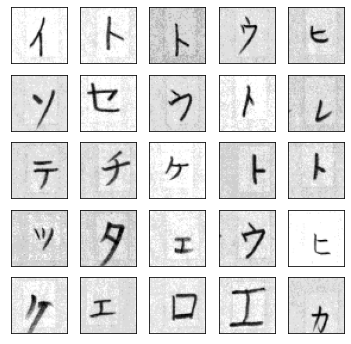

In [ ]:
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kana_train_images[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
#Preprocess Hiragana
hira = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

hira = hira/np.max(hira)

#71 characters, 160 writers, transform image to 48*48
hira_train_images = np.zeros([71 * 160, 48, 48], dtype=np.float32)

for i in range(71 * 160):
    hira_train_images[i] = skimage.transform.resize(hira[i], (48, 48))

arr = np.arange(71)
hira_train_labels = np.repeat(arr, 160) # create labels

#split to train and test
hira_train_images, hira_test_images, hira_train_labels, hira_test_labels = train_test_split(hira_train_images, hira_train_labels, test_size=0.2)

np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_train_images.npz", hira_train_images)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_train_labels.npz", hira_train_labels)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_test_images.npz", hira_test_images)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_test_labels.npz", hira_test_labels)

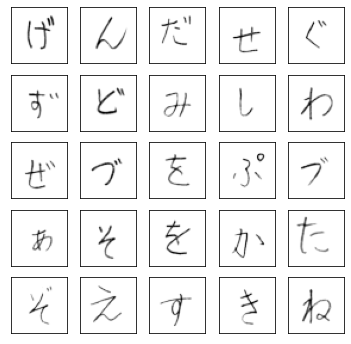

In [ ]:
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(hira_train_images[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
#Preprocess Kanji
kan = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

kan_train_images = np.zeros([879 * 160, 48, 48], dtype=np.float32)

#4 characters were actually hiragana, so delete these 4 extras
for i in range( (879+4) * 160):
	if int(i/160) != 88 and int(i/160) != 219 and int(i/160) != 349 and int(i/160) != 457:
		if int(i/160) < 88:
			kan_train_images[i] = skimage.transform.resize(kan[i], (48, 48))
		if int(i/160) > 88 and int(i/160) < 219:
			kan_train_images[i-160] = skimage.transform.resize(kan[i], (48, 48))
		if int(i/160) > 219 and int(i/160) < 349:
			kan_train_images[i-320] = skimage.transform.resize(kan[i], (48, 48))
		if int(i/160) > 349 and int(i/160) < 457:
			if int(i/160) > 457:
				kan_train_images[i-640] = skimage.transform.resize(kan[i], (48, 48))
		
arr = np.arange(879)
kan_train_labels = np.repeat(arr, 160)

      
kan_train_images, kan_test_images, kan_train_labels, kan_test_labels = train_test_split(kan_train_images, kan_train_labels, test_size=0.2)

np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_train_images.npz", kan_train_images)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_train_labels.npz", kan_train_labels)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_test_images.npz", kan_test_images)
np.savez_compressed("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_test_labels.npz", kan_test_labels)

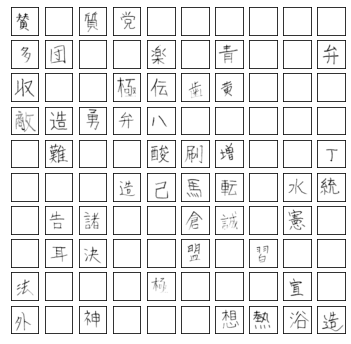

In [ ]:
plt.figure(figsize=(6,6))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kan_train_images[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
#CNN Katakana

kana_train_images = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_train_images.npz")['arr_0']
kana_train_labels = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_train_labels.npz")['arr_0']
kana_test_images = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_test_images.npz")['arr_0']
kana_test_labels = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/katakana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first": #reshape the image to be able to go through 2D CNN
  kana_train_images = kana_train_images.reshape(kana_train_images.shape[0], 1,48,48)
  kana_test_images2 = kana_test_images.reshape(kana_test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  kana_train_images = kana_train_images.reshape(kana_train_images.shape[0], 48, 48, 1)
  kana_test_images2 = kana_test_images.reshape(kana_test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)

#model building
datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(kana_train_images)
kana_model = keras.Sequential([
  keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(48, activation="softmax")
])

In [ ]:
kana_model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
kana_model.fit_generator(datagen.flow(kana_train_images,kana_train_labels,shuffle=True),epochs=30,validation_data=(kana_test_images2,kana_test_labels),
                         callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),
                                      keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
1799/1799 [==============================] - 126s 70ms/step - loss: 0.9317 - accuracy: 0.7348 - val_loss: 0.1770 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 2/30
1799/1799 [==============================] - 123s 68ms/step - loss: 0.3483 - accuracy: 0.8984 - val_loss: 0.1203 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 3/30
1799/1799 [==============================] - 126s 70ms/step - loss: 0.2626 - accuracy: 0.9245 - val_loss: 0.1032 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/30
1799/1799 [==============================] - 125s 69ms/step - loss: 0.2224 - accuracy: 0.9369 - val_loss: 0.1121 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 5/30
1799/1799 [==============================] - 126s 70ms/step - loss: 0.1989 - accuracy: 0.9435 - val_loss: 0.0946 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/30
1799/1799 [==============================] - 128s 71ms/step - loss: 0.1799 - accuracy: 0.9499 - val_loss: 0.0919 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 7/30
1799/1799 [==================

In [ ]:
kana_model.save("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.h5") 

In [ ]:
kana_model = keras.models.load_model("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.h5")
kana_model.summary()
kana_model.evaluate(kana_test_images,kana_test_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

[0.06611020117998123, 0.9868677258491516]

In [ ]:
kana_model = tf.keras.models.load_model("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.h5")
print(kana_model.outputs)
print(kana_model.inputs)

[<tf.Tensor 'dense_1_1/Softmax:0' shape=(None, 48) dtype=float32>]
[<tf.Tensor 'conv2d_input_1:0' shape=(None, 48, 48, 1) dtype=float32>]


In [ ]:
#Convert h5 file to pb file
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
from keras import backend as K
import os
import os.path as osp

path_to_model = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.h5'
saved_model_path = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katkana-model'
model = load_model(path_to_model)
nb_classes = 1 # The number of output nodes in the model
prefix_output_node_names_of_final_network = 'output_node'

K.set_learning_phase(0)

pred = [None]*nb_classes
pred_node_names = [None]*nb_classes
for i in range(nb_classes):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

sess = K.get_session()
output_graph_name = saved_model_path + '.pb'
output_graph_suffix = '_inference'

constant_graph = tf.compat.v1.graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

In [ ]:
#Convert h5 file to tflite file
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(kana_model)
tflite_model = converter.convert()

# Save the model.
with open('/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.tflite', 'wb') as f:
  f.write(tflite_model)


In [ ]:
#CNN Hiragana
hira_train_images = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_train_images.npz")['arr_0']
hira_train_labels = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_train_labels.npz")['arr_0']
hira_test_images = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_test_images.npz")['arr_0']
hira_test_labels = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/hiragana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  hira_train_images = hira_train_images.reshape(hira_train_images.shape[0], 1,48,48)
  hira_test_images2 = hira_test_images.reshape(hira_test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  hira_train_images = hira_train_images.reshape(hira_train_images.shape[0], 48, 48, 1)
  hira_test_images2 = hira_test_images.reshape(hira_test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)

datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(hira_train_images)

hira_model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dense(71, activation="softmax")
])


#test_loss, test_acc = model.evaluate(hira_test_images2, hira_test_labels)
#print("Test Accuracy: ", test_acc)


In [ ]:
hira_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
hira_model.fit_generator(datagen.flow(hira_train_images,hira_train_labels,shuffle=True),epochs=30,
                         validation_data=(hira_test_images2,hira_test_labels),
                         callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),
                                      keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
284/284 [==============================] - 8s 26ms/step - loss: 2.1919 - accuracy: 0.4279 - val_loss: 0.6800 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 2/30
284/284 [==============================] - 7s 26ms/step - loss: 0.8247 - accuracy: 0.7461 - val_loss: 0.3601 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 3/30
284/284 [==============================] - 7s 26ms/step - loss: 0.5675 - accuracy: 0.8237 - val_loss: 0.2201 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 4/30
284/284 [==============================] - 8s 26ms/step - loss: 0.4293 - accuracy: 0.8618 - val_loss: 0.1790 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 5/30
284/284 [==============================] - 8s 27ms/step - loss: 0.3408 - accuracy: 0.8878 - val_loss: 0.1613 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 6/30
284/284 [==============================] - 8s 27ms/step - loss: 0.2963 - accuracy: 0.9013 - val_loss: 0.1638 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 7/30
284/284 [==============================] - 8s 26ms/st

In [ ]:
hira_model.save("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/hiragana-model.h5")

In [ ]:
keras.models.load_model("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/hiragana-model.h5")
hira_model.summary()
hira_model.evaluate(hira_test_images,hira_test_labels)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)        

[0.032427120953798294, 0.9903169274330139]

In [ ]:
hira_model = tf.keras.models.load_model("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/hiragana-model.h5")
print(hira_model.outputs)
print(hira_model.inputs)

In [ ]:
#Convert h5 file to pb file
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
from keras import backend as K
import os
import os.path as osp

path_to_model = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/hiragana-model.h5'
saved_model_path = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/hiragana-model'
model = load_model(path_to_model)
nb_classes = 1 # The number of output nodes in the model
prefix_output_node_names_of_final_network = 'output_node'

K.set_learning_phase(0)

pred = [None]*nb_classes
pred_node_names = [None]*nb_classes
for i in range(nb_classes):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

sess = K.get_session()
output_graph_name = saved_model_path + '.pb'
output_graph_suffix = '_inference'

constant_graph = tf.compat.v1.graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

In [ ]:
#Convert h5 file to tflite file
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(kana_model)
tflite_model = converter.convert()

# Save the model.
with open('/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.tflite', 'wb') as f:
  f.write(tflite_model)


In [ ]:
#CNN Kanji
kan_train_images = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_train_images.npz")['arr_0']
kan_train_labels = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_train_labels.npz")['arr_0']
kan_test_images = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_test_images.npz")['arr_0']
kan_test_labels = np.load("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Files ver.2/kanji_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  kan_train_images = kan_train_images.reshape(kan_train_images.shape[0], 1,48,48)
  kan_test_images = kan_test_images.reshape(kan_test_images.shape[0], 1,48,48)
  shape = (1,48,48)
else:
  kan_train_images = kan_train_images.reshape(kan_train_images.shape[0], 48, 48, 1)
  kan_test_images = kan_test_images.reshape(kan_test_images.shape[0], 48, 48, 1)
  shape = (48,48,1)
  
datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(kan_train_images)
kan_model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(879, activation="softmax")
])


#test_loss, test_acc = model.evaluate(test_images, test_labels)
#print("Test Accuracy: ", test_acc)


In [ ]:
kan_model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
kan_model.fit_generator(datagen.flow(kan_train_images,kan_train_labels,shuffle=True),epochs=50,
                        validation_data=(kan_test_images,kan_test_labels),
                        callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),
                                     keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
3516/3516 [==============================] - 139s 39ms/step - loss: 4.6711 - accuracy: 0.2084 - val_loss: 3.9372 - val_accuracy: 0.3551 - lr: 0.0010
Epoch 2/50
3516/3516 [==============================] - 139s 40ms/step - loss: 4.0524 - accuracy: 0.3258 - val_loss: 3.8603 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 3/50
3516/3516 [==============================] - 136s 39ms/step - loss: 3.9783 - accuracy: 0.3451 - val_loss: 3.8380 - val_accuracy: 0.3824 - lr: 0.0010
Epoch 4/50
3516/3516 [==============================] - 137s 39ms/step - loss: 3.9379 - accuracy: 0.3560 - val_loss: 3.8294 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 5/50
3516/3516 [==============================] - 140s 40ms/step - loss: 3.9177 - accuracy: 0.3616 - val_loss: 3.8261 - val_accuracy: 0.3874 - lr: 0.0010
Epoch 6/50
3516/3516 [==============================] - 137s 39ms/step - loss: 3.9017 - accuracy: 0.3662 - val_loss: 3.8217 - val_accuracy: 0.3861 - lr: 0.0010
Epoch 7/50
3516/3516 [==================

In [ ]:
kan_model.save("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/kanji-model.h5")

In [ ]:
keras.models.load_model("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/kanji-model.h5")
kan_model.summary()
kan_model.evaluate(kan_test_images,kan_test_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dropout_2 (Dropout)         (None, 6400)             

[3.7910068035125732, 0.39640215039253235]

In [ ]:
kan_model = tf.keras.models.load_model("/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/kanji-model.h5")
print(kan_model.outputs)
print(kan_model.inputs)

In [ ]:
#Convert h5 file to pb file
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
from keras import backend as K
import os
import os.path as osp

path_to_model = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/kanji-model.h5'
saved_model_path = '/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/kanji-model'
model = load_model(path_to_model)
nb_classes = 1 # The number of output nodes in the model
prefix_output_node_names_of_final_network = 'output_node'

K.set_learning_phase(0)

pred = [None]*nb_classes
pred_node_names = [None]*nb_classes
for i in range(nb_classes):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

sess = K.get_session()
output_graph_name = saved_model_path + '.pb'
output_graph_suffix = '_inference'

constant_graph = tf.compat.v1.graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

In [ ]:
#Convert h5 file to tflite file
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(kana_model)
tflite_model = converter.convert()

# Save the model.
with open('/content/MyDrive/MyDrive/Japanese Handwritting Recognition/Model/katakana-model.tflite', 'wb') as f:
  f.write(tflite_model)
